In [63]:
import pandas as pd
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizerFast, XLMRobertaModel
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy

# read data from file

In [6]:
file_path = "en_gold.txt"
with open(file_path, "rt", encoding="utf-8") as file:
    lines = file.readlines()

In [7]:
sentences = []  # list of dictionaries
current_sentence_tokens = []  # initialize the list
current_sentence_labels = []  # initialize the list
current_sentence = {'sentence': [], 'labels': []}  # dictionary for each sentence specifying the tokens and the labels

for line in lines:
    line = line.strip().split('\t')
    if len(line) == 1:
        if current_sentence_tokens:
            sentences.append({
                'sentence': current_sentence_tokens,
                'labels': current_sentence_labels
            })
            current_sentence_tokens = []  # reset the list for the next sentence
            current_sentence_labels = []  # reset the list for the next sentence
    else:
        current_sentence_tokens.append(line[0])
        current_sentence_labels.append(line[-1])

# add the last sentence if not empty
if current_sentence_tokens:
    sentences.append({
        'sentence': current_sentence_tokens,
        'labels': current_sentence_labels
    })

# print(sentences[:5])
# print(len(sentences))


# transform tags to numeric values

In [8]:
all_labels = [label for sentence in sentences for label in sentence['labels']]
unique_labels = set(all_labels)
num_unique_labels = len(unique_labels)
print(unique_labels)
print(num_unique_labels) # 72

# create a mapping from tags to numeric values
tag_to_index = {tag: idx for idx, tag in enumerate(unique_labels)}
# print(tag_to_index)

# map labels to numeric values using tag_to_index
mapped_dataset = []
for example in sentences:
    mapped_labels = [tag_to_index[label] for label in example['labels']]
    mapped_example = {'sentence': example['sentence'], 'labels': mapped_labels}
    mapped_dataset.append(mapped_example)

# print some examples from the mapped dataset
print(mapped_dataset[:5])


{'ART', 'CTC', 'PRX', 'EFS', 'REL', 'PER', 'GRE', 'DEG', 'NIL', 'LIT', 'REF', 'DST', 'PRO', 'GPO', 'QUE', 'PRG', 'EXG', 'COL', 'GEO', 'FUT', 'NOT', 'PST', 'SUB', 'EMP', 'YOC', 'CLO', 'EQU', 'SST', 'ITJ', 'NOW', 'ROL', 'XCL', "RP'", 'NTH', 'ORD', 'UOM', 'HAP', 'IST', 'PFT', 'BOT', 'QUC', 'GPE', 'BUT', 'TOP', 'LES', 'IMP', 'PRI', 'EXT', 'PRP', 'DEF', 'GRP', 'ALT', 'APX', 'NNP', 'DOW', 'INT', 'HAS', 'POS', 'CON', 'COO', 'EXS', 'MOY', 'ORG', 'MOR', 'EPS', 'DOM', 'SCO', 'DIS', 'NEC', 'AND', 'ENS', 'QUV'}
72
[{'sentence': ['A', 'brown', 'dog', 'and', 'a', 'grey', 'dog', 'are', 'fighting', 'in', 'the', 'snow'], 'labels': [67, 17, 58, 50, 67, 17, 58, 29, 16, 4, 49, 58]}, {'sentence': ['A', 'woman', 'in', 'a', 'white', 'dress', 'and', 'a', 'woman', 'in', 'a', 'blue', 'dress', 'are', 'standing', 'on', 'a', 'stage'], 'labels': [67, 58, 4, 67, 17, 58, 50, 67, 58, 4, 67, 17, 58, 29, 16, 4, 67, 58]}, {'sentence': ['There', 'is', 'no', 'man', 'playing', 'two', 'keyboards'], 'labels': [8, 29, 20, 58, 

In [11]:
bronze_tags = {'IST', 'BOT', 'CON', 'GRP', 'TOP', 'ENS', 'MOR', 'GPE', 'APX', 'GPO', 'QUE', 'BUT', 'DOW', 'YOC', 'NTH', 'EFS', 'ANA', 'MOY', 'NNP', 'REF', 'EXG', 'ORG', 'LES', 'DOM', 'PRX', 'ALT', 'NEC', 'PRO', 'SUB', 'PER', 'EMP', 'HAP', 'CLO', 'DEG', 'EXT', 'POS', 'NIL', 'DIS', 'FUT', 'QUV', 'GEO', 'CTC', 'ORD', 'ART', 'EPS', 'AND', 'INT', 'DXT', 'EXS', 'REL', 'IMP', 'DEF', 'LIT', 'QUC', 'HAS', 'NOW', 'PRG', 'SCO', "CD'", 'EQU', 'PFT', 'GRE', 'XCL', 'UOM', 'ITJ', 'PST', 'COL', 'NOT', 'ROL', 'COO', 'DST'} # bronze

gold_tags = {'IST', 'BOT', 'GRP', 'CON', 'APX', 'ENS', 'MOR', 'GPE', 'TOP', 'GPO', 'PRP', 'PRI', 'QUE', 'BUT', 'DOW', 'YOC', 'NTH', 'EFS', 'MOY', 'NNP', 'REF', 'ORG', 'EXG', 'LES', 'DOM', 'PRX', 'ALT', 'NEC', 'PRO', 'SUB', 'PER', 'EMP', 'HAP', 'CLO', 'DEG', 'EXT', 'POS', 'NIL', 'DIS', 'FUT', 'GEO', 'QUV', 'CTC', 'ORD', 'ART', 'EPS', 'AND', 'INT', 'EXS', 'REL', 'IMP', 'DEF', 'LIT', 'QUC', 'HAS', 'NOW', 'PRG', 'SCO', 'EQU', "RP'", 'PFT', 'GRE', 'UOM', 'XCL', 'ITJ', 'PST', 'COL', 'SST', 'NOT', 'ROL', 'COO', 'DST'} # gold

silver_tags = {'BOT', 'APX', 'GPO', 'NTH', 'EFS', 'REF', 'EXG', 'HAP', 'CLO', 'CTC', 'ORD', 'REL', 'NOW', "CD'", 'CON', "DT'", 'ACT', 'GPE', 'PRP', 'YOC', 'ORG', 'LES', 'DOM', 'PER', 'EMP', 'DEG', 'EXT', 'DIS', 'IMP', 'QUC', 'SCO', 'ITJ', 'COM', 'DST', 'NNS', 'IST', 'HES', 'MOR', 'TOP', 'BUT', 'QUE', 'NNP', 'PRO', 'SUB', "JJ'", 'NIL', 'FUT', 'DXT', 'AND', 'DEF', 'LIT', 'PRG', 'EQU', 'DAT', 'GRE', 'UNK', 'PST', 'COL', 'SST', 'NOT', 'GRP', 'ENS', "NN'", 'DOW', 'ANA', 'MOY', 'PRX', 'ALT', 'NEC', 'POS', 'QUV', 'GEO', 'ART', 'EPS', 'INT', 'EXS', 'DXP', 'HAS', 'PFT', 'UOM', 'XCL', 'ROL', 'COO'}  # silver


# Find overlapped tags
overlapped_tags = bronze_tags.intersection(gold_tags, silver_tags)

# Find unique tags in each set
unique_bronze_tags = bronze_tags.difference(gold_tags, silver_tags)
unique_gold_tags = gold_tags.difference(bronze_tags, silver_tags)
unique_silver_tags = silver_tags.difference(bronze_tags, gold_tags)

# Combine all unique tags from the three sets
all_unique_tags = bronze_tags.union(gold_tags, silver_tags)

# Print results
print("Overlapped Tags:", overlapped_tags)
print(len(overlapped_tags))
print("Unique Tags in Bronze:", unique_bronze_tags)
print("Unique Tags in Gold:", unique_gold_tags)
print("Unique Tags in Silver:", unique_silver_tags)
print("All Unique Tags:", all_unique_tags)

Overlapped Tags: {'GRE', 'EPS', 'IMP', 'INT', 'TOP', 'SUB', 'LIT', 'ORG', 'HAP', 'ROL', 'QUV', 'DEG', 'PFT', 'NEC', 'UOM', 'QUC', 'EXS', 'NNP', 'AND', 'MOY', 'IST', 'NIL', 'PST', 'PRG', 'EMP', 'POS', 'EXG', 'DST', 'NTH', 'REF', 'SCO', 'NOT', 'GPE', 'ORD', 'NOW', 'DOW', 'PRO', 'MOR', 'ALT', 'EFS', 'EQU', 'CLO', 'QUE', 'GPO', 'COL', 'DOM', 'DEF', 'CTC', 'YOC', 'PRX', 'GEO', 'EXT', 'BUT', 'ART', 'REL', 'XCL', 'ENS', 'FUT', 'LES', 'CON', 'BOT', 'DIS', 'PER', 'APX', 'HAS', 'GRP', 'ITJ', 'COO'}
68
Unique Tags in Bronze: set()
Unique Tags in Gold: {'PRI', "RP'"}
Unique Tags in Silver: {'UNK', "JJ'", 'NNS', "NN'", "DT'", 'DAT', 'HES', 'COM', 'ACT', 'DXP'}
All Unique Tags: {'EPS', 'PFT', 'QUC', 'EXS', 'MOY', 'NIL', 'PST', 'EMP', 'GPE', 'ORD', 'UNK', 'MOR', 'EQU', 'BUT', 'ART', 'XCL', 'SST', 'APX', 'COO', 'INT', 'SUB', 'LIT', 'QUV', 'DEG', 'AND', 'PRG', 'NOT', 'COM', 'EFS', 'CLO', 'QUE', 'GPO', 'DOM', 'DEF', "CD'", 'YOC', 'GEO', "RP'", 'REL', 'CON', 'PER', 'GRP', 'GRE', 'IMP', 'PRI', 'ORG', 'HAP

# train/val/test split

In [9]:
# set a random seed for reproducibility
random_seed = 42

# split the dataset into training, validation, and test sets
train_data, temp_data = train_test_split(mapped_dataset, test_size=0.3, random_state=random_seed)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=random_seed)

# print the sizes of each set
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_data)}")
print(train_data[:5])
print(val_data[:5])
print(test_data[:5])

Number of training samples: 7773
Number of validation samples: 1666
Number of test samples: 1666
[{'sentence': ['Subway~fares', 'will', 'be', 'raised', 'as~of', 'April', '1st'], 'labels': [58, 19, 8, 60, 4, 61, 65]}, {'sentence': ['Thou', 'speakest', '.'], 'labels': [12, 70, 8]}, {'sentence': ['Two', 'sheep', 'were', 'killed', 'by', 'a', 'wolf', '.'], 'labels': [40, 58, 21, 60, 4, 67, 58, 8]}, {'sentence': ['The', 'police', 'charged', 'Sachiyo', 'with', 'the', 'murder', '.'], 'labels': [49, 58, 64, 5, 4, 49, 58, 8]}, {'sentence': ['Tom', 'grabbed', 'a', 'letter~opener', 'off', 'his', 'desk', '.'], 'labels': [5, 64, 67, 58, 4, 56, 58, 8]}]
[{'sentence': ['Tom', 'owes', 'Mary', 'three~hundred', 'dollars', '.'], 'labels': [5, 70, 5, 40, 35, 8]}, {'sentence': ['Tom', "\\'s", 'computer', 'crashed', 'and', 'he', 'lost', 'a', 'number', 'of', 'important', 'documents', '.'], 'labels': [5, 56, 58, 64, 59, 12, 64, 67, 71, 4, 37, 58, 8]}, {'sentence': ['In', 'which', 'city', 'is', 'the', 'River', 

change data structure to datasets for the map function later

In [30]:
# train_data, val_data, and test_data are lists of dictionaries
train_dataset = Dataset.from_dict({"sentence": [item['sentence'] for item in train_data], "labels": [item['labels'] for item in train_data]})
val_dataset = Dataset.from_dict({"sentence": [item['sentence'] for item in val_data], "labels": [item['labels'] for item in val_data]})
test_dataset = Dataset.from_dict({"sentence": [item['sentence'] for item in test_data], "labels": [item['labels'] for item in test_data]})


In [31]:
print(train_dataset[:5])
print(type(train_dataset))

{'sentence': [['Subway~fares', 'will', 'be', 'raised', 'as~of', 'April', '1st'], ['Thou', 'speakest', '.'], ['Two', 'sheep', 'were', 'killed', 'by', 'a', 'wolf', '.'], ['The', 'police', 'charged', 'Sachiyo', 'with', 'the', 'murder', '.'], ['Tom', 'grabbed', 'a', 'letter~opener', 'off', 'his', 'desk', '.']], 'labels': [[58, 19, 8, 60, 4, 61, 65], [12, 70, 8], [40, 58, 21, 60, 4, 67, 58, 8], [49, 58, 64, 5, 4, 49, 58, 8], [5, 64, 67, 58, 4, 56, 58, 8]]}
<class 'datasets.arrow_dataset.Dataset'>


# tokenization

In [38]:
# load the tokenizer
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [39]:
def tokenize_and_align_labels(examples, label_all_tokens=False, skip_index=-100):
    tokenized_inputs = tokenizer(examples["sentence"], truncation=True, is_split_into_words=True, padding=True)
    labels = []

    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids : list[int] = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(skip_index)

            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])

            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else skip_index)

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print out some tokenized examples

In [40]:
tokenized_examples = tokenize_and_align_labels(train_dataset[:5])
# print([example["sentence"] for example in train_data[:5]])
# print(tokenized_examples)

# print the original and tokenized sentences along with numeric labels
for i in range(5):
    original_sentence = train_data[i]["sentence"]
    tokenized_sentence = tokenizer.decode(tokenized_examples["input_ids"][i], skip_special_tokens=True)

    tokenized_labels = tokenized_examples["labels"][i]

    print(f"Original sentence: {original_sentence}")
    print(f"Tokenized sentence: {tokenized_sentence}")
    print(f"Tokenized numeric labels: {tokenized_labels}\n")


Original sentence: ['Subway~fares', 'will', 'be', 'raised', 'as~of', 'April', '1st']
Tokenized sentence: Subway~fares will be raised as~of April 1st
Tokenized numeric labels: [-100, 58, -100, -100, -100, -100, 19, 8, 60, 4, -100, -100, 61, 65, -100, -100]

Original sentence: ['Thou', 'speakest', '.']
Tokenized sentence: Thou speakest.
Tokenized numeric labels: [-100, 12, -100, 70, -100, 8, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Original sentence: ['Two', 'sheep', 'were', 'killed', 'by', 'a', 'wolf', '.']
Tokenized sentence: Two sheep were killed by a wolf.
Tokenized numeric labels: [-100, 40, 58, -100, 21, 60, 4, 67, 58, -100, 8, -100, -100, -100, -100, -100]

Original sentence: ['The', 'police', 'charged', 'Sachiyo', 'with', 'the', 'murder', '.']
Tokenized sentence: The police charged Sachiyo with the murder.
Tokenized numeric labels: [-100, 49, 58, 64, -100, 5, -100, 4, 49, 58, 8, -100, -100, -100, -100, -100]

Original sentence: ['Tom', 'grabbed', 'a', 'letter~

In [41]:
batch_size = 16
# apply the mapping function
tokenized_dataset_train = train_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset_val = val_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset_test = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/7773 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

In [43]:
print(tokenized_dataset_test[:1])

{'sentence': [['The', 'ice', 'is', 'melting', '.']], 'labels': [[-100, 49, 58, -100, 29, 16, -100, 8, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]], 'input_ids': [[0, 581, 6, 2980, 83, 21501, 1916, 6, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


# data loading

In [77]:
# create custom collate fn for dataloaders
def custom_collate_fn(batch):
    input_ids = [torch.tensor(item["input_ids"]) for item in batch]
    attention_mask = [torch.tensor(item["attention_mask"]) for item in batch]
    labels = [torch.tensor(item["labels"]) for item in batch]  # Fix the key to "label"

    # pad the sequences to the same length
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # 0 as the padding value for attention_mask

    # stack the labels
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-100)  # Assuming -100 as the padding value for labels

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "label": labels_padded
    }

# create PyTorch DataLoaders using custom_collate_fn
train_dataloader = DataLoader(tokenized_dataset_train, shuffle=True, collate_fn=custom_collate_fn, batch_size=batch_size)
val_dataloader = DataLoader(tokenized_dataset_val, shuffle=False, collate_fn=custom_collate_fn, batch_size=batch_size)
test_dataloader = DataLoader(tokenized_dataset_test, shuffle=False, collate_fn=custom_collate_fn, batch_size=batch_size)

In [79]:
# iterate over the first 5 batches
for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx >= 2:
        break

    input_ids_batch = batch['input_ids']
    attention_mask_batch = batch['attention_mask']
    labels_batch = batch['label']

    print(f"Batch {batch_idx + 1}:")
    print(f"Input IDs shape: {input_ids_batch.shape}")
    print(f"Attention Mask shape: {attention_mask_batch.shape}")
    print(f"Labels shape: {labels_batch.shape}")
    print()

    # print the content of the first example in the batch
    print(f"Input IDs: {input_ids_batch[0]}")
    print(f"Attention Mask: {attention_mask_batch[0]}")
    print(f"Labels: {labels_batch[0]}")

    print(f"Input IDs shape: {input_ids_batch.shape}")
    print(f"Attention Mask shape: {attention_mask_batch.shape}")
    print(f"Labels shape: {labels_batch.shape}")
    print()

Batch 1:
Input IDs shape: torch.Size([16, 56])
Attention Mask shape: torch.Size([16, 56])
Labels shape: torch.Size([16, 56])

Input IDs: tensor([     0,    581,   5324,    509,  10336,    214, 144477,      6,      5,
             2,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Labels: tensor([-100,   49,   58,   21,   16, -100,   58,    8, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100,

# defining model

In [67]:
class SemanticTaggingModel(nn.Module):
    def __init__(self, num_pos_tags):
        super(SemanticTaggingModel, self).__init__()

        # XLM-RoBERTa model
        self.roberta = XLMRobertaModel.from_pretrained("xlm-roberta-base")

        # linear layer
        self.linear = nn.Linear(768, num_pos_tags)

    def forward(self, input_ids, attention_mask):
        # XLM-RoBERTa forward pass
        roberta_outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = roberta_outputs.last_hidden_state

        # linear layer
        logits = self.linear(hidden_states)

        return logits

Epoch 1, Average Training Loss: 1.2515170901952457, Training Accuracy: 0.7451128363609314
Epoch 1, Validation Accuracy: 0.9317291975021362
Epoch 2, Average Training Loss: 0.2703457161814833, Training Accuracy: 0.9473738074302673
Epoch 2, Validation Accuracy: 0.9643846154212952
Epoch 3, Average Training Loss: 0.15920569429580322, Training Accuracy: 0.9680651426315308
Epoch 3, Validation Accuracy: 0.9710684418678284
Epoch 4, Average Training Loss: 0.11176908212434117, Training Accuracy: 0.9767375588417053
Epoch 4, Validation Accuracy: 0.9741239547729492
Epoch 5, Average Training Loss: 0.08682907639462271, Training Accuracy: 0.9806350469589233
Epoch 5, Validation Accuracy: 0.9758426547050476


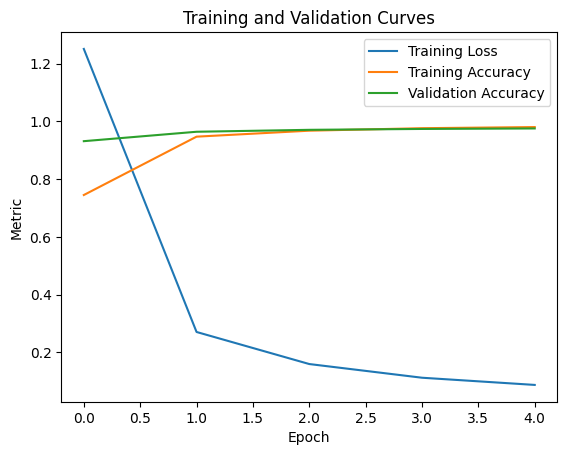

In [68]:
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SemanticTaggingModel(num_pos_tags=72).to(device)

# define the loss function and optimizer
loss_function = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore tokens with label -100
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 5
train_losses = []   # for plotting
train_accuracies = [] # for plotting
val_accuracies = []  # for plotting

for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions_train = 0
    total_tokens_train = 0

    model.train()
    # iterate over batches
    for batch_idx, batch in enumerate(train_dataloader):
        # Move inputs and gold outputs to GPU
        inputs, gold_outputs = batch['input_ids'].to(device), batch['label'].to(device)

        # ignore tokens with label -100 for loss calculation
        valid_tokens_mask = (gold_outputs != -100)

        # forward pass
        predicted_logits = model(inputs, attention_mask=batch['attention_mask'].to(device))

        # reshape predicted_logits for the loss function
        predicted_logits_flat = predicted_logits.view(-1, model.linear.out_features)[valid_tokens_mask.view(-1)]
        gold_outputs_flat = gold_outputs.view(-1)[valid_tokens_mask.view(-1)]

        # calculate the loss
        batch_loss = loss_function(predicted_logits_flat, gold_outputs_flat)

        # backward pass and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

        # calculate training accuracy considering only valid tokens
        train_predictions = torch.argmax(predicted_logits, dim=-1)
        correct_predictions_train += torch.sum(train_predictions[valid_tokens_mask] == gold_outputs[valid_tokens_mask])
        total_tokens_train += torch.sum(valid_tokens_mask)

    # calculate average loss and training accuracy for the epoch
    average_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions_train.float() / total_tokens_train.float()
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}, Average Training Loss: {average_loss}, Training Accuracy: {train_accuracy}")

    # Validation
    model.eval()
    correct_predictions = 0
    total_tokens = 0

    with torch.no_grad():
        for val_batch in val_dataloader:
            # move validation inputs and gold outputs to GPU
            val_inputs, val_gold_outputs = val_batch['input_ids'].to(device), val_batch['label'].to(device)

            # forward pass
            val_logits = model(val_inputs, attention_mask=val_batch['attention_mask'].to(device))

            # calculate accuracy considering only valid tokens
            val_predictions = torch.argmax(val_logits, dim=-1)
            valid_tokens_mask = (val_gold_outputs != -100)

            # apply mask to predictions
            val_predictions_masked = val_predictions[valid_tokens_mask]
            correct_predictions += torch.sum(val_predictions_masked == val_gold_outputs[valid_tokens_mask])
            total_tokens += torch.sum(valid_tokens_mask)

    val_accuracy = correct_predictions.float() / total_tokens.float()
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy.item()}")

    # adjust learning rate based on validation loss
    scheduler.step(average_loss)



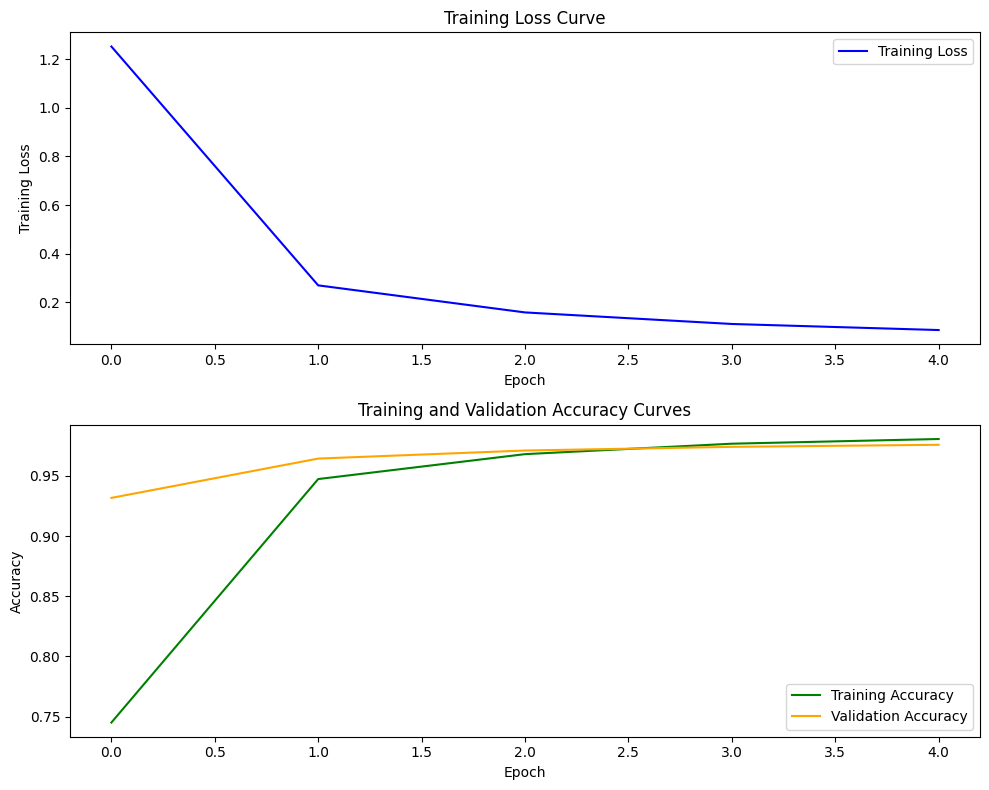

In [80]:
# plot learning curves
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# plot training loss
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.set_title('Training Loss Curve')
ax1.legend()

# plot training and validation accuracy
ax2.plot([acc.cpu().numpy() for acc in train_accuracies], label='Training Accuracy', color='green')
ax2.plot([acc.cpu().numpy() for acc in val_accuracies], label='Validation Accuracy', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curves')
ax2.legend()

plt.tight_layout()
plt.show()